# Evaluate and Compare Optimizers

Some classes and functions to allow different optimization algorithms to be compared.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from dataclasses import dataclass
import skopt

import lpfgopt
lpfgopt.__version__

'1.0.1'

In [2]:
from platform import python_version
python_version()

'3.10.18'

## Optimization Problem Definition

In [3]:
@dataclass
class ConstrainedScalarOptimizationProblem():
    _name: str
    _guesses: list
    _input_dim: int
    _bounds: np.ndarray
    _global_minimum: np.ndarray

    def __init__(self, bounds, name=None, global_minimum=None):
        self._bounds = bounds
        self._input_dim = len(bounds)
        self._name = name
        self._global_minimum = global_minimum
        self.reset()

    def reset(self):
        self._guesses = []

    @property
    def name(self) -> str:
        return self._name

    @property
    def input_dim(self) -> tuple:
        return self._input_dim

    @property
    def bounds(self) -> np.ndarray:
        return self._bounds

    @property
    def global_minimum(self) -> np.ndarray:
        return self._global_minimum

    @property
    def nfev(self) -> int:
        return len(self._guesses)

    @property
    def guesses(self) -> list:
        return self._guesses

    @property
    def best_guess(self) -> tuple:
        return min(self._guesses)

    @staticmethod
    def cost_function_to_minimize(x, *args) -> float:
        # Implement cost function to minimize here
        cost = 0.0
        return cost

    def __call__(self, x, *args) -> float:
        assert np.all(
            (b[0] <= xi) and (xi <= b[1]) for b, xi in zip(self._bounds, x)
        )
        cost = self.cost_function_to_minimize(x, *args)
        self._guesses.append((cost, x))
        return cost


### Example 1. Toy 1D Problem

In [4]:
class Toy1DProblem(ConstrainedScalarOptimizationProblem):

    def __init__(self):
        bounds = [(-5.0, 5.0)]
        name = "Toy1DProblem"
        super().__init__(bounds, name=name, global_minimum=[2.5085382557867626])

    @staticmethod
    def cost_function_to_minimize(x) -> float:
        return 1.0 / (-0.05 * x[0] ** 2 - np.cos(x[0]) + 0.25 * np.sin(3 * x[0] + 0.8) + 5)


# Test problem instance
problem = Toy1DProblem()
assert str(problem) == (
    "Toy1DProblem(_name='Toy1DProblem', _guesses=[], _input_dim=1, "
    "_bounds=[(-5.0, 5.0)], _global_minimum=[2.5085382557867626])"
)
assert problem.bounds == [(-5.,  5.)]
assert problem.input_dim == 1
assert problem.nfev == 0
assert problem.guesses == []
assert problem([0.5]) == 0.23275605031813504
assert problem.guesses == [(0.23275605031813504, [0.5])]
assert problem.nfev == 1
assert problem([-5]) == 0.3108649328945798
assert problem([5]) == 0.29041392127738885
assert problem.nfev == 3
assert problem.best_guess == (0.23275605031813504, [0.5])

# Find global minimum using Scipy and a good initial guess
sol = scipy.optimize.minimize(problem, x0=2.5, bounds=problem.bounds, tol=1e-15)
assert sol.status == 0
print(sol.fun, sol.x.item())
assert np.array_equal(problem.global_minimum, sol.x)

0.17499977934365754 2.5085382557867626


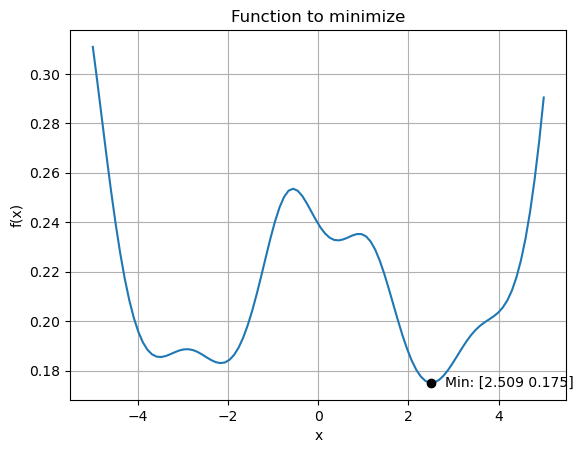

In [6]:
X = np.linspace(-5, 5, 100).reshape(1, -1)
Y = problem(X)

min_pt = np.array([problem.global_minimum[0], problem(problem.global_minimum)])

plt.plot(X.T, Y.T)
plt.plot(*min_pt, 'ko')
plt.annotate(f'Min: {min_pt.round(3)}', min_pt, xytext=(10, 0),
             textcoords='offset points', va='center')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Function to minimize')
plt.grid()

In [9]:
def solve_problem_with_optimizer(problem, minimizer, *args, **kwargs):
    problem.reset()
    sol = minimizer(problem, *args, **kwargs)
    return sol

rng = np.random.default_rng(0)
x0 = rng.uniform(*zip(*problem.bounds))
sol = solve_problem_with_optimizer(problem, scipy.optimize.minimize, x0, bounds=problem.bounds)
sol

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 0.17499977934672517
        x: [ 2.509e+00]
      nit: 5
      jac: [ 7.411e-07]
     nfev: 16
     njev: 8
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

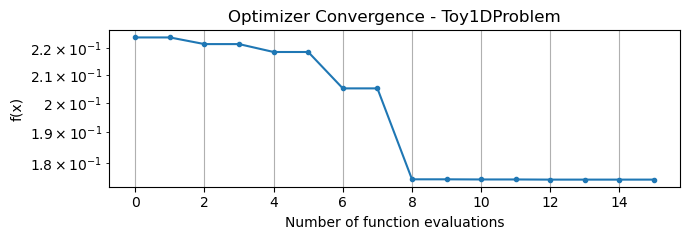

In [10]:
def convergence_plot(problem, title=None):
    if title is None:
        title = f'Optimizer Convergence - {problem.name}'
    fevals = np.array([item[0] for item in problem.guesses])
    fig = plt.figure(figsize=(7, 2.5))
    ax = fig.gca()
    plt.semilogy(fevals, marker='.')
    plt.xlabel('Number of function evaluations')
    plt.ylabel('f(x)')
    plt.grid()
    plt.title(title)
    return ax

convergence_plot(problem)
plt.tight_layout()
plt.show()

In [11]:
solve_problem_with_optimizer(problem, lpfgopt.minimize, problem.bounds)

        best: [np.float64(0.17499977934365832), 2.508538095242799]
 final_error: np.float64(9.505723654335771e-06)
         fun: np.float64(0.17499977934365832)
       maxcv: 0
     message: 'Tolerance condition satisfied'
        nfev: 314
         nit: 294
    pointset: [[np.float64(0.17499977934367433), 2.5085388422735275], [np.float64(0.17499977934373803), 2.508536884134455], [np.float64(0.17499977934368102), 2.50853895451548], [np.float64(0.17499977934388702), 2.508540497466093], [np.float64(0.17499977934375455), 2.5085367528533435], [np.float64(0.17499977934367075), 2.5085376837374396], [np.float64(0.1749997793437726), 2.5085366213996814], [np.float64(0.17499977934365832), 2.508538095242799], [np.float64(0.17499977934365854), 2.5085380763691956], [np.float64(0.17499977934389158), 2.508540519852191], [np.float64(0.1749997793439301), 2.508540701258586], [np.float64(0.17499977934396815), 2.5085355881601075], [np.float64(0.17499977934366126), 2.508537938866308], [np.float64(0.1749997

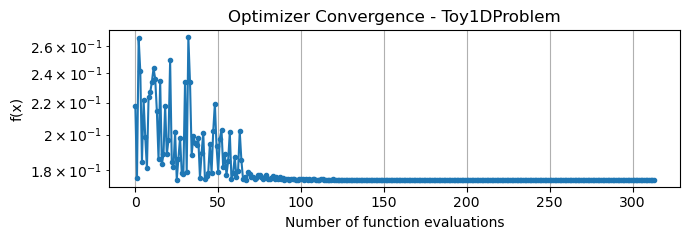

In [12]:
convergence_plot(problem)
plt.tight_layout()
plt.show()

In [13]:
# TODO: Plot variance of convergence results

from collections import Counter

def solve_problem_with_optimizer_n_repeats(
    problem, minimizer, n_repeats, *args, decimals=6, **kwargs
):

    solutions = []
    fun_evals = []
    for i in range(n_repeats):
        problem.reset()
        sol = minimizer(problem, *args, **kwargs)
        solutions.append(tuple(round(float(xi), decimals) for xi in sol.x))
        fun_evals.append(np.array([f[0] for f in problem.guesses]))
    unique_solutions = Counter(solutions)
    return fun_evals, unique_solutions

fun_evals, unique_solutions = solve_problem_with_optimizer_n_repeats(problem, lpfgopt.minimize, 20, problem.bounds, tol=1e-6)
unique_solutions

Counter({(2.508538,): 17, (-2.158829,): 3})

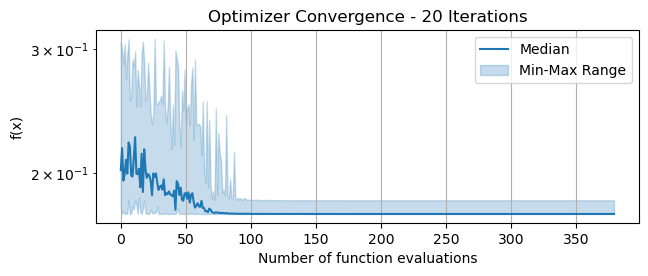

In [14]:
def convergence_plot_n_repeats(fun_evals, title=None, marker='auto', color='tab:blue', alpha=0.25):

    n_repeats = len(fun_evals)

    if title is None:
        title = f'Optimizer Convergence - {n_repeats} Iterations'

    # Find the maximum length among all sequences
    max_len = max(len(f) for f in fun_evals)

    # Extend all sequences to the same length by repeating their final value
    series_array = np.full((n_repeats, max_len), np.nan)
    for i, f in enumerate(fun_evals):
        n = len(f)
        series_array[i, :n] = f
        series_array[i, n:] = f[-1]

    # Calculate min, max, and median across all series at each iteration
    min_vals = np.min(series_array, axis=0)
    max_vals = np.max(series_array, axis=0)
    median_vals = np.median(series_array, axis=0)

    # Create the plot
    fig = plt.figure(figsize=(7, 2.5))
    ax = fig.gca()

    # Plot the median line
    if marker == 'auto':
        marker = '.' if max_len < 20 else None
    x = np.arange(max_len)
    ax.semilogy(x, median_vals, marker=marker, color=color, label='Median')

    # Fill between min and max
    ax.fill_between(x, min_vals, max_vals, alpha=alpha, color=color, label='Min-Max Range')

    plt.xlabel('Number of function evaluations')
    plt.ylabel('f(x)')
    plt.grid()
    plt.title(title)
    plt.legend()
    
    return ax

ax = convergence_plot_n_repeats(fun_evals)

## Bayesian Optimization Minimizer

In [24]:
# Run Bayesian optimization
problem.reset()
res = skopt.gp_minimize(
    problem,            # the function to minimize
    problem.bounds,     # the bounds on each dimension of x
    n_calls=50,
    noise=1e-10,
    random_state=0
)
res

          fun: 0.17499984847992295
            x: [2.5072929577707797]
    func_vals: [ 2.353e-01  1.955e-01 ...  1.756e-01  1.754e-01]
      x_iters: [[0.9284461822501839], [3.442657485810175], [3.57945617622757], [3.472517387841256], [1.2356369678597243], [-1.1561829270730009], [-2.0246539345552765], [-4.432870226825568], [-2.2734370541988675], [-0.22334882678650025], [5.0], [2.5030594692913137], [-3.2221318696656196], [2.743344028134663], [-2.8069034687684584], [2.317653026177748], [2.557596688912204], [-5.0], [2.5189660786095116], [-3.7564665277672393], [4.292437907269585], [1.899371734104025], [-1.6517761649824632], [0.3222397301344948], [-3.5034307569808063], [3.029664927966447], [-4.061359949586361], [3.997995038411373], [-2.526741066995071], [2.5279331268239247], [2.5217513951707353], [2.604702868396748], [2.491545826479779], [2.4375392268522713], [2.560639771259643], [2.441180995888824], [2.4840975816507127], [2.4454324764558617], [2.48505723377297], [2.413420828004514], [2.43

In [25]:
res['x'], res['fun']

([2.5072929577707797], np.float64(0.17499984847992295))

In [26]:
problem.best_guess

(np.float64(0.17499984847992295), [2.5072929577707797])

In [21]:
fun_evals, unique_solutions = solve_problem_with_optimizer_n_repeats(
    problem, skopt.gp_minimize, 20, problem.bounds, noise=1e-10, n_calls=50
)
unique_solutions

Counter({(2.509755,): 1,
         (2.508851,): 1,
         (2.509009,): 1,
         (2.508646,): 1,
         (2.508283,): 1,
         (2.510564,): 1,
         (2.510712,): 1,
         (2.507995,): 1,
         (2.508196,): 1,
         (2.505441,): 1,
         (2.505809,): 1,
         (2.511338,): 1,
         (2.509418,): 1,
         (2.507329,): 1,
         (2.507336,): 1,
         (2.513654,): 1,
         (2.516925,): 1,
         (2.506568,): 1,
         (2.509774,): 1,
         (2.507747,): 1})

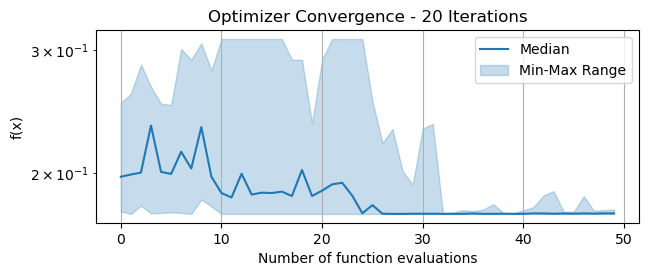

In [22]:
ax = convergence_plot_n_repeats(fun_evals)